In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel,Field

In [3]:
load_dotenv()

True

In [4]:
model = ChatGoogleGenerativeAI(model= "gemini-2.5-flash")

In [6]:
class ReviewSchema(BaseModel):

    sentiment : Literal['positive','negative'] = Field(description= "Sentiment of the review")


class DiagnosisSchema(BaseModel):

    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [7]:
structure_model = model.with_structured_output(ReviewSchema)
structure_model2 = model.with_structured_output(DiagnosisSchema)

In [8]:
prompt = " Find the sentiment of the provided review -The boys has too smart "
structure_model.invoke(prompt).sentiment

'positive'

In [9]:
class ReviewState(TypedDict):

    review:str
    sentiment :Literal['positive','negative']
    diagnosis : dict
    response : str



In [10]:
def find_sentiment(state:ReviewState):

    prompt = f'find the sentiment of the following review \n {state["review"]}'
    sentiment= structure_model.invoke(prompt).sentiment


    return {'sentiment':sentiment}

    

In [11]:
def check_sentiment(state: ReviewState):

    if state['sentiment']=='positive':
        return 'positive_response'
    
    else:
        return 'run_diagnosis'

In [12]:
def positive_response(state:ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
     Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response' :response}

In [13]:
def run_diagnosis(state:ReviewState):

    prompt =  f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    
    response = structure_model2.invoke(prompt) 
    return {'diagnosis' :response.model_dump()} 

In [14]:
def negative_response(state:ReviewState):
    diagnosis = state['diagnosis']
    prompt =  f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message."""
    
    response = model.invoke(prompt)

    return {'response': response }

In [15]:
graph =  StateGraph(ReviewState)

In [16]:
graph =  StateGraph(ReviewState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()
workflow = graph.compile()

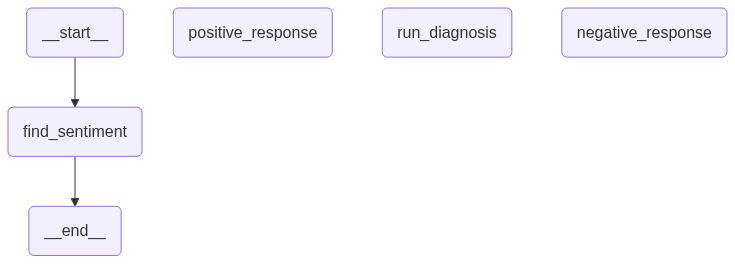

In [17]:
workflow

In [18]:
intial_state = {'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."}

result = workflow.invoke(intial_state)
print(result)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.', 'sentiment': 'negative', 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'}, 'response': AIMessage(content='Subject: Resolution: Your High-Priority Bug Report - [Briefly mention the bug area if known, e.g., "Login Issue," "Data Saving Error"]\n\nDear [User\'s Name, if known, or Valued User],\n\nI understand how incredibly frustrating it can be when a bug disrupts your work, especially when it\'s a high-priority issue that needs immediate attention. Please accept our sincere apologies for the inconvenience and stress this has caused you.\n\nI\'m happy to inform you that our technical team has thoroughly investigated the bug you reported and has successfully deployed a fix. We identified the root cause and implemented a so

In [19]:
intial_state['review']

'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.'